# Centroid Measurement

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle
from astropy.io import fits
%matplotlib widget

The following script uploads the first science corrected frame

In [144]:
# Carico la lista dei file science
science_list = np.genfromtxt('./group10_WASP-135_20190803/science/science.list', dtype=str)
# Come per l'analisi fatta nella lezione precedente, carico solo i primi 30 frames.
science_test_list = science_list[:30]
# In questa variabile immagazzino il nome del primo corrected science frame.
science_frame_name = './group10_WASP-135_20190803/correct/' + science_test_list[0][:-5] + '_corr.p'
# Carico il file corrispondente a questo nome
science_corrected = pickle.load(open(science_frame_name, 'rb'))

### Identification of the target and reference stars

We now open and display a scientific frame and we identify the target star (the one with the transiting planet) and the reference stars (used to do differential photometry). By changing the $\texttt{vmin}$ and $\texttt{vmax}$ we can highlight fainter stars.

vmin:  1067.9   vmax: 110239.3


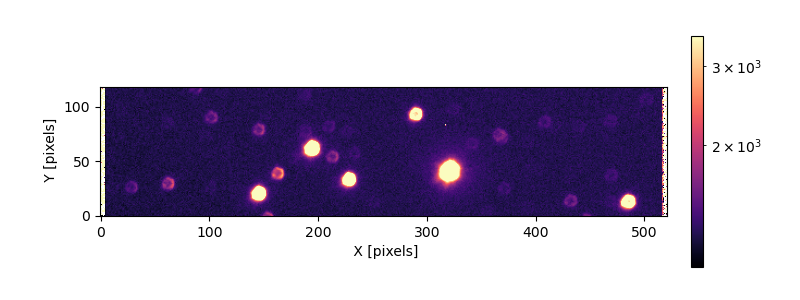

In [145]:
import matplotlib.colors as colors

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}   vmax: {1:.1f}'.format(vmin, vmax))

#Abbassiamo il vmax altrimenti non si vede molto
vmax=3500

fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.show()


From this frame we can get an approximate location of the star (in pixels). In this case we got:

- x_target = 228
- y_target = 33

- x_reference_01 = 146
- y_reference_01 = 21

- x_reference_02 = 194
- y_reference_02 = 62

- x_reference_03 = 290
- y_reference_03 = 93

- x_reference_04 = 322
- y_reference_04 = 40

We don't need to be extremely precise at this stage, we will refine the coordinates afterwards. In the next cell there is a function that creates a plot, we use a function since we will use this plot a lot and we need to be able to call it often.

In [146]:
def make_circle_around_star_v1(ax, x_pos, y_pos, label='', color='w'):
    """
    This function creates a circle around the selected target in the science frame.

    Parameters:
    - x_pos: x coordinate of the target.
    - y_pos: y coordinate of the target.

    It does not return a variable but it produces a plot instead.
    """
    from matplotlib.patches import Circle # Serve per disegnare cerchi su un grafico

    n, radii = 50, [9, 15] #Numero di punti con cui approssimare la circonferenze e due raggi
    theta = np.linspace(0, 2*np.pi, n, endpoint=True) # Genera n valori di theta tra 0 e 2pi.
    xs = np.outer(radii, np.cos(theta)) # crea coordinata x per ogni raggio e theta
    ys = np.outer(radii, np.sin(theta)) # stessa cosa per la coordinata y

    #Il cerchio che abbiamo è in realtà un anello dato da un cerchio interno e uno esterno e noi coloriamo
    #la parte fra i due cerchi.

    # in order to have a closed area, the circles should be traversed in opposite directions
    xs[1,:] = xs[1,::-1] # L'ordine dei punti è importante per il corretto riempimento dell'area
    ys[1,:] = ys[1,::-1] # Deve essere cambiato perché ax.fill() lavora al contrario rispetto a come li abbiamo definiti

    #ax.fill riempie l'area tra i due cerchi
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=0.75, label=label)


With this function we can draw as many circles as we want by simply adding one line of code. We run the following code many times until the position of the circles are centered on the stars.

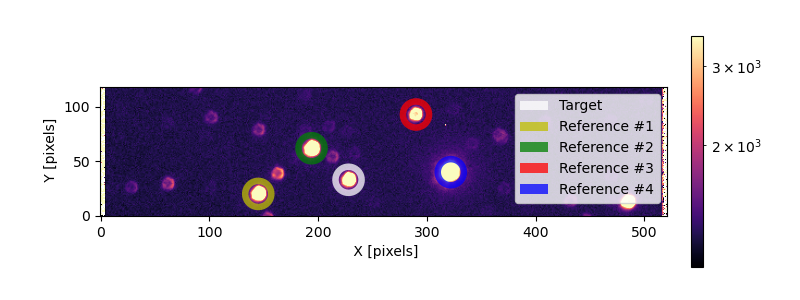

In [147]:
x_target = 228
y_target = 33

x_reference_01 = 145
y_reference_01 = 20

x_reference_02 = 194
y_reference_02 = 62

x_reference_03 = 290
y_reference_03 = 93

x_reference_04 = 322
y_reference_04 = 40

fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

make_circle_around_star_v1(ax, x_target, y_target, label='Target', color='w')
make_circle_around_star_v1(ax, x_reference_01, y_reference_01, label='Reference #1', color='y')
make_circle_around_star_v1(ax, x_reference_02, y_reference_02, label='Reference #2', color='g')
make_circle_around_star_v1(ax, x_reference_03, y_reference_03, label='Reference #3', color='r')
make_circle_around_star_v1(ax, x_reference_04, y_reference_04, label='Reference #4', color='b')

plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
ax.legend()
plt.show()

### Photocenter determination of a star
The $\textbf{photocentre}$ of a star is the centre of light production defined as the centre of an Airy disk. In our analysis, we will use this term to identify the average position of the target on the sensor. The light distribution will have an irregular shape if the telescope has been defocused on purpose when collecting light curves for transit detection.
Here are the reasons why we defocus when collecting light curves
- **Reduction of atmospheric noise**: Defocusing spreads light over multiple pixels, reducing the effects of atmospheric turbulence and improving photometric stability.

- **Better signal-to-noise ratio (SNR)**: Prevents sensor saturation and reduces readout noise, increasing measurement accuracy.

- **More accurate differential photometry**: Smoother light profiles minimize systematic errors caused by pixel sensitivity variations.

- **Minimization of defective pixel effects**: Spreading light across multiple pixels reduces the impact of anomalous or non-uniform pixels.

- **Higher tolerance to guiding errors**: A defocused image makes small telescope tracking errors less critical.

In order to have a clearer idea of the possible radius from the star's centre at which the star flux is negligible we need a 3D plot. We start by employing the numpy.meshgrid function to build two 2D arrays X and Y. Each array has the same shape as our frames and contain che x and y coordinate of the corresponding pixel.

In [148]:
ylen, xlen = np.shape(science_corrected)
print('Shape of our science frame: {0:d} x {1:d}'.format(xlen, ylen))
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)
# print('Shape of our 2D arrays: {0} , {1}'.format(np.shape(X), np.shape(Y)))
# print(X, Y)

Shape of our science frame: 521 x 119


We want to plot the flux on the z axis but we don't want to be affected by the nasty values in the overscan region.

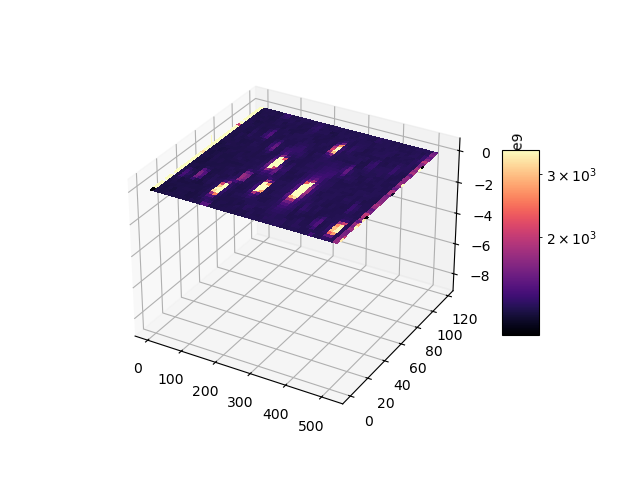

In [149]:
# subplot_kw={"projection": "3d"} dice a matplotlib di creare un sistema di coordinate 3D per ax
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# plot_surface disegna una superficie tridimensionale
surf = ax.plot_surface(X, Y, science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), linewidth=0, antialiased=False)
# antialising è una tecnica per smussare i bordi

# shrink = 0.5 riduce l'altezza della barra dei colori al 50% di quella predefinita
# aspect = 5 significa che sarà 5 volte più alta che larga.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Now we make a few improvements:
1. We centre the 3d plot around the estimated coordinates of our target;
2. We limit our plot within a radius of 15 pixels around the centre of the target;
3. We change the $\texttt{vmax}$ value to 20000 to display more details;
4. We make the colorbar smaller and thinner.

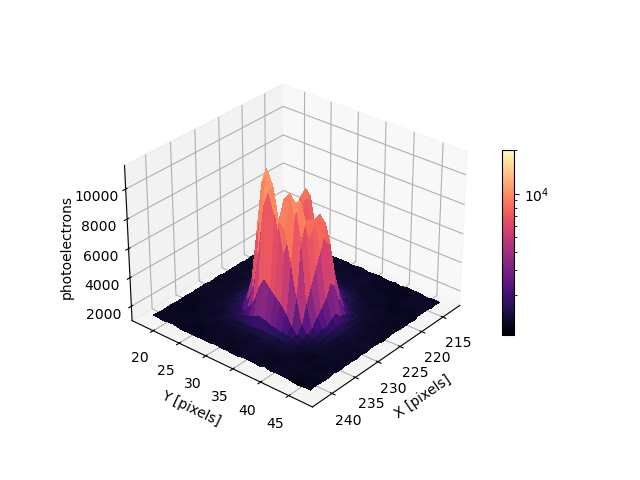

In [150]:
vmax = 20000
radius_plot = 15

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface
surf = ax.plot_surface(X[y_target-radius_plot:y_target+radius_plot, x_target-radius_plot:x_target+radius_plot],
                       Y[y_target-radius_plot:y_target+radius_plot, x_target-radius_plot:x_target+radius_plot],
                       science_corrected[y_target-radius_plot:y_target+radius_plot, x_target-radius_plot:x_target+radius_plot],
                       cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin, vmax),
                       linewidth=0, antialiased=False)

# Questi parametri controllano la rotazione orizzontale e verticale della visualizzazione

ax.azim = 40 #value in degree
ax.elev = 30

ax.set_xlabel('X [pixels]')
ax.set_ylabel('Y [pixels]')

# Fix the orientation fo the Z label
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('photoelectrons', rotation=90)

## Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=15, ticks=[10, 100, 1000, 10000, 100000])

plt.show()



### Advantages of using $\texttt{numpy.meshgrid}$
Computing two 2D arrays containing one of the two coordinates of each pixel may appear as an unnecessary complication. If we want to compute the distance of each pixel from the photocentre we need this information.
We will now compare two algorithms, one with meshgrid and one without it and measure how much time it takes.


In [151]:
# First Algortihm - Iterate over each pixel
import time

t0 = time.time()

rr_method01 = np.zeros_like(science_corrected)
for y_i in range(0, np.shape(science_corrected)[0]):
    for x_i in range(0, np.shape(science_corrected)[1]):
        rr_method01[y_i, x_i] = np.sqrt((x_i - x_target)**2 + (y_i - y_target)**2)

t1 = time.time()

total_method01 = t1- t0
print('Time required by the first method: {0:f} seconds'.format(total_method01))



Time required by the first method: 0.117951 seconds


In [152]:
# Second Algortihm - Meshgrid

t0 = time.time()

X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

t1 = time.time()

rr_method02 = np.sqrt((X - x_target)**2 + (Y - y_target)**2)

t2 = time.time()

prepare_method02 = t1 - t0
total_method02 = t2 - t1

print('Time required to set up the second algorithm: {0:f} seconds'.format(prepare_method02))
print('Time required by second algorithm:            {0:f} seconds'.format(total_method02))

Time required to set up the second algorithm: 0.000999 seconds
Time required by second algorithm:            0.000795 seconds


### Centroid Algorithm
We need to determine the centre of this distribution. We need:
1. A fast algorithm (needs to run hundreds of times).
2. A robust algorithm that reaches convergence regardless of initizl conditions and perturbations.
3. A simple algorithm that can work without any prior knowledge of the PSF of the instrument as the defocusing change night by night.

We use a **weighted centroid** method, weighing the coordinates of each pixel accordin to the flux and compute the average within a distance from the centre.
The *inner radius* must be large enough to include all the flux coming from the star, and some sky background as well.

Before starting, we need to make sure that the inner radius fully includes the star's flux. In the following code the vmax is set to twice the background level to highlight the boundaries of the star. We present a good example and a bad example for inner radius.

vmin:  1067.9    vmax: 110239.3


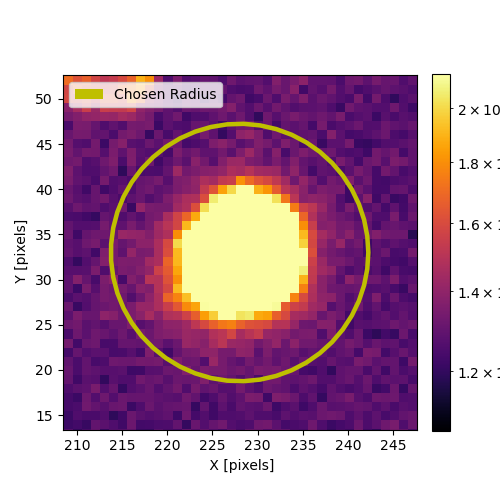

In [153]:
# We redefine the make circle function so that it take the radius as an argument

def make_circle_around_star(ax, x_pos, y_pos, radius, thickness=0.5, label='', color='w'):
    from matplotlib.patches import Circle

    n, radii = 50, [radius, radius+thickness]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=1., label=label)

from matplotlib import colors

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))
vmax = 2*vmin

fig, ax = plt.subplots(1, figsize=(5,5))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['inferno'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

good_inner_radius = 14
bad_inner_radius = 8

# Cut the plot around the target star, with some margin with respect to the inner radius
plt.xlim(x_target-good_inner_radius*1.4, x_target+good_inner_radius*1.4)
plt.ylim(y_target-good_inner_radius*1.4, y_target+good_inner_radius*1.4)

make_circle_around_star(ax, x_target, y_target, good_inner_radius, label='Chosen Radius', color='y')

plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.legend(loc='upper left')
plt.show()

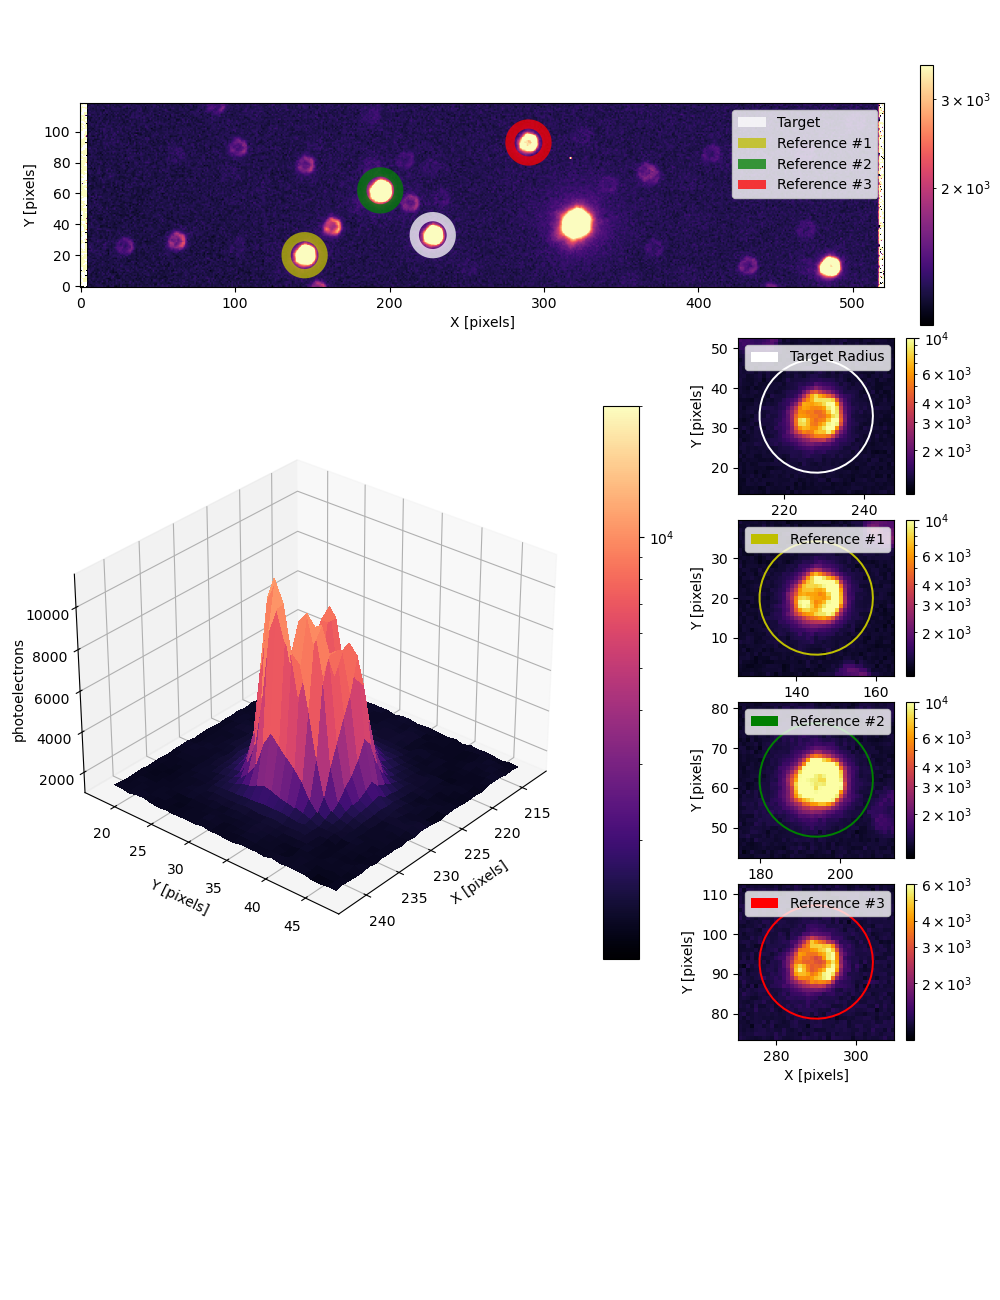

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

# Creiamo la figura
fig = plt.figure(figsize=(10,13))

# -----------------
# PLOT 1 (10x4) in alto
# -----------------
vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
#Abbassiamo il vmax altrimenti non si vede molto
vmax=3500
ax1 = fig.add_axes([0.08, 0.75, 0.88, 0.2])  # (x, y, width, height)
im1 = ax1.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

make_circle_around_star_v1(ax1, x_target, y_target, label='Target', color='w')
make_circle_around_star_v1(ax1, x_reference_01, y_reference_01, label='Reference #1', color='y')
make_circle_around_star_v1(ax1, x_reference_02, y_reference_02, label='Reference #2', color='g')
make_circle_around_star_v1(ax1, x_reference_03, y_reference_03, label='Reference #3', color='r')

ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')
ax1.legend()

# -----------------
# PLOT 2 (7x9) in basso a sinistra
# -----------------
vmax = 20000
radius_plot = 15
ax2 = fig.add_axes([0.05, 0.05, 0.65, 0.85], projection='3d')  # (x, y, width, height)
surf = ax2.plot_surface(X[y_target-radius_plot:y_target+radius_plot, x_target-radius_plot:x_target+radius_plot],
                         Y[y_target-radius_plot:y_target+radius_plot, x_target-radius_plot:x_target+radius_plot],
                         science_corrected[y_target-radius_plot:y_target+radius_plot, x_target-radius_plot:x_target+radius_plot],
                         cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin, vmax),
                         linewidth=0, antialiased=False)

ax2.azim = 40  # Rotazione orizzontale
ax2.elev = 30  # Angolo di elevazione
ax2.set_xlabel('X [pixels]')
ax2.set_ylabel('Y [pixels]')
ax2.zaxis.set_rotate_label(False)
ax2.set_zlabel('photoelectrons', rotation=90)
fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=15, ticks=[10, 100, 1000, 10000, 100000])

# -----------------
# PLOT 3 (in alto nella colonna di destra)
# -----------------
vmax = 10000
ax3 = fig.add_axes([0.62, 0.62, 0.3, 0.12])  # (x, y, width, height)
im3 = ax3.imshow(science_corrected, cmap=plt.colormaps['inferno'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

ax3.set_xlim(x_target-good_inner_radius*1.4, x_target+good_inner_radius*1.4)
ax3.set_ylim(y_target-good_inner_radius*1.4, y_target+good_inner_radius*1.4)

make_circle_around_star(ax3, x_target, y_target, good_inner_radius, label='Target Radius', color='w')


ax3.set_ylabel('Y [pixels]')
ax3.legend(loc='upper left')

# -----------------
# PLOT 4 (sotto Plot 3)
# -----------------
ax4 = fig.add_axes([0.62, 0.48, 0.3, 0.12])
im4 = ax4.imshow(science_corrected, cmap=plt.colormaps['inferno'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
fig.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)

ax4.set_xlim(x_reference_01-good_inner_radius*1.4, x_reference_01+good_inner_radius*1.4)
ax4.set_ylim(y_reference_01-good_inner_radius*1.4, y_reference_01+good_inner_radius*1.4)

make_circle_around_star(ax4, x_reference_01, y_reference_01, good_inner_radius, label='Reference #1', color='y')

ax4.set_ylabel('Y [pixels]')
ax4.legend(loc='upper left')

# -----------------
# PLOT 5 (sotto Plot 4)
# -----------------
ax5 = fig.add_axes([0.62, 0.34, 0.3, 0.12])
im5 = ax5.imshow(science_corrected, cmap=plt.colormaps['inferno'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
fig.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)

ax5.set_xlim(x_reference_02-good_inner_radius*1.4, x_reference_02+good_inner_radius*1.4)
ax5.set_ylim(y_reference_02-good_inner_radius*1.4, y_reference_02+good_inner_radius*1.4)

make_circle_around_star(ax5, x_reference_02, y_reference_02, good_inner_radius, label='Reference #2', color='g')


ax5.set_ylabel('Y [pixels]')
ax5.legend(loc='upper left')

# -----------------
# PLOT 6 (sotto Plot 5, ultimo in basso)
# -----------------
vmax=6000
ax6 = fig.add_axes([0.62, 0.20, 0.3, 0.12])
im6 = ax6.imshow(science_corrected, cmap=plt.colormaps['inferno'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
fig.colorbar(im6, ax=ax6, fraction=0.046, pad=0.04)

ax6.set_xlim(x_reference_03-good_inner_radius*1.4, x_reference_03+good_inner_radius*1.4)
ax6.set_ylim(y_reference_03-good_inner_radius*1.4, y_reference_03+good_inner_radius*1.4)

make_circle_around_star(ax6, x_reference_03, y_reference_03, good_inner_radius, label='Reference #3', color='r')

ax6.set_xlabel('X [pixels]')
ax6.set_ylabel('Y [pixels]')
ax6.legend(loc='upper left')

plt.show()

In [155]:
# Centroid Algortihm

# Initial coordinates of the target and radius
# x_target, y_target
inner_radius = good_inner_radius #[Pixels]

# Compute the meshgrid, we do this again since this algorithm will be exported to the class later
ylen, xlen = np.shape(science_corrected)
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

# Compute the distance between each pixel and the target
target_distance = np.sqrt((X-x_target)**2 + (Y-y_target)**2) #It's a matrix

# Selection of the pixels within the selected radius
'''In this case we have a 2D boolean array, if target_distance > inner_radius we find False, otherwise True'''
annulus_selection = (target_distance < inner_radius)

# Weighted sum of coordinates: each point is worth its flux (if inside the radius).
weighted_X = np.sum(science_corrected[annulus_selection]*X[annulus_selection])
weighted_Y = np.sum(science_corrected[annulus_selection]*Y[annulus_selection])

# Sum of the weights
total_flux = np.sum(science_corrected[annulus_selection])

# Refined determination of coordinates
x_target_refined = weighted_X/total_flux
y_target_refined = weighted_Y/total_flux


print('Initial coordinates  x: {0:5.2f}   y: {1:5.2f}'.format(x_target, y_target))
print('Refined coordinates  x: {0:5.2f}   y: {1:5.2f}'.format(x_target_refined, y_target_refined))

Initial coordinates  x: 228.00   y: 33.00
Refined coordinates  x: 228.29   y: 32.95


Our algorithm needs an initial guess, also called *starting point* which is the main pitfall of other methods such as Markov Chain Monte Carlo algorithms. In this case our starting point is an approximate centre of a big circle taken with our mouse.
We want to see what happens to the refined data if we change the initial guess. If our guess is too far from the actual value we would maybe have to reiterate the process a few times before obtaining the correct value.
To do so, we include our algorithm in a cicle and set the tolerance as a percent variance between two consecutive iterations.

Initial coordinates  x: 232.00   y: 30.00
    Iteration   0   x: 230.435 (-0.67%)  y: 31.349 (4.50%)
    Iteration   1   x: 229.603 (-0.36%)  y: 32.095 (2.38%)
    Iteration   2   x: 229.132 (-0.21%)  y: 32.490 (1.23%)
    Iteration   3   x: 228.925 (-0.09%)  y: 32.683 (0.59%)
    Iteration   4   x: 228.740 (-0.08%)  y: 32.777 (0.29%)
    Iteration   5   x: 228.674 (-0.03%)  y: 32.824 (0.14%)
    Iteration   6   x: 228.657 (-0.01%)  y: 32.845 (0.07%)
Refined coordinates  x: 228.66   y: 32.85
vmin:  1067.9    vmax: 110239.3


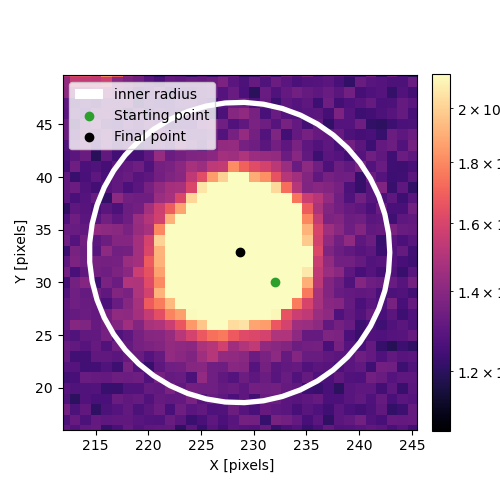

In [156]:
# Centroid Algorithm v2

# Initial coordinates of the target
x_target_initial = x_target+4
y_target_initial = y_target-3

maximum_iterations = 30

# Computing again the meshgrid arrays 
ylen, xlen = np.shape(science_corrected)
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

print('Initial coordinates  x: {0:5.2f}   y: {1:5.2f}'.format(x_target_initial, y_target_initial))

for i in range(0, maximum_iterations):

    if i == 0:
        # First iteration
        x_target_previous = x_target_initial
        y_target_previous = y_target_initial
    else:
        # Using the previous result as starting point
        x_target_previous = x_target_refined
        y_target_previous = y_target_refined

    # 2D array with the distance
    target_distance = np.sqrt((X-x_target_previous)**2 + (Y-y_target_previous)**2)

    # Selection of the pixels within the inner radius
    annulus_selection = (target_distance < inner_radius)

    # Weighted sum of coordinates
    weighted_X = np.sum(science_corrected[annulus_selection]*X[annulus_selection])
    weighted_Y = np.sum(science_corrected[annulus_selection]*Y[annulus_selection])

    # Sum of the weights
    total_flux = np.sum(science_corrected[annulus_selection])

    # Refined determination of coordinates
    x_target_refined = weighted_X/total_flux
    y_target_refined = weighted_Y/total_flux

    percent_variance_x = (x_target_refined - x_target_previous)/(x_target_previous) * 100
    percent_variance_y = (y_target_refined - y_target_previous)/(y_target_previous) * 100

    print('    Iteration {0:3d}   x: {1:.3f} ({2:.2f}%)  y: {3:.3f} ({4:.2f}%)'.format(i, x_target_refined, percent_variance_x, y_target_refined, percent_variance_y))

    # Exit Condition
    if np.abs(percent_variance_x)<0.1 and np.abs(percent_variance_y)<0.1:
        break

print('Refined coordinates  x: {0:5.2f}   y: {1:5.2f}'.format(x_target_refined, y_target_refined))

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))
vmax = 2*vmin

fig, ax = plt.subplots(1, figsize=(5,5))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

# Cut the plot around the target star, with some margin with respect to the inner radius
plt.xlim(x_target_refined-inner_radius*1.2, x_target_refined+inner_radius*1.2)
plt.ylim(y_target_refined-inner_radius*1.2, y_target_refined+inner_radius*1.2)

make_circle_around_star(ax, x_target_refined, y_target_refined, inner_radius, label='inner radius')

ax.scatter(x_target_initial, y_target_initial, c='C2', label='Starting point')
ax.scatter(x_target_refined, y_target_refined, c='k', label='Final point')

plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.legend(loc='upper left')
plt.show()



Even in a case of wrong guess, the algorithm converges to the correct position.

### Full Width Half Maximum of the Centroid

We want to determine how large is our star, not just the position of the photocentre. Knowing the scale of a pixel, we can convert this information onto the measured *seeing*.
We are measuring the **Full Width at Half Maximum (FWHM)** of our centroid to determine the apparent size of our star in the image. This measurement does not only account for the atmospheric seeing but also includes the intentional defocus applied to the telescope.

##### Why is FWHM important?
- **Characterizing the total seeing**: The measured FWHM represents the combination of atmospheric turbulence and defocus, giving us the effective spread of the star's light in the image.
- **Optimizing aperture photometry**: Knowing the FWHM helps define the best aperture size to include most of the star's light while minimizing background noise.
- **Monitoring image quality**: Changes in FWHM over time can indicate variations in atmospheric conditions or issues with the telescope's focus.
- **Converting to physical scales**: By knowing the pixel scale, we can express the FWHM in arcseconds, which helps compare observations under different conditions.

This ensures that our photometric measurements remain accurate and consistent throughout the analysis.


C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_9820\3315257173.py:9: RuntimeWarning: invalid value encountered in multiply
  total_flux = np.nansum(science_corrected*annulus_selection)
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_9820\3315257173.py:14: RuntimeWarning: invalid value encountered in multiply
  flux_x = np.nansum(science_corrected*annulus_selection, axis=0)
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_9820\3315257173.py:15: RuntimeWarning: invalid value encountered in multiply
  flux_y = np.nansum(science_corrected*annulus_selection, axis=1)


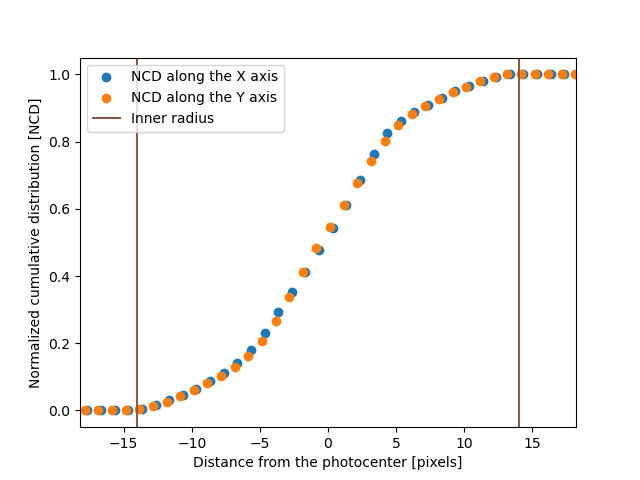

In [157]:
# flux within the annulus 
# 2D array with the distance of each pixel from the target star 
target_distance = np.sqrt((X-x_target_refined)**2 + (Y-y_target_refined)**2)

# Selection of the pixels within the inner radius
annulus_selection = (target_distance < inner_radius)

# We compute the sum of the total flux within the inner radius.
total_flux = np.nansum(science_corrected*annulus_selection) 

# We compute the sum of the flux along each axis, within the inner radius.
# nansum ignores the nan values in the frame (overscan regions).
# Quando moltiplico science_corrected per annulus_selection, i True sono 1 e i False sono 0
flux_x = np.nansum(science_corrected*annulus_selection, axis=0) 
flux_y = np.nansum(science_corrected*annulus_selection, axis=1) 

# we compute the cumulative sum along each axis, normalized to the total flux
'''cumsum restituisce la somma cumulativa di un array sotto forma di array. Ad esempio
np.cumsum[1,2,3,4] restituisce l'array [1, 3, 6, 10] dove in ogni entrata vi è la somma degli elementi
precedenti ad essa. Nel nostro caso lo impieghiamo perché ci permette di capire mano a mano che ci spostiamo
lungo x o lungo y quanto flusso stiamo accumulando in modo da sapere quando entriamo nella FWHM (tra 25% e 75%
del flusso totale).'''
cumulative_sum_x = np.cumsum(flux_x)/total_flux # Somma cumulativa normalizzata sul flusso totale lungo x
cumulative_sum_y = np.cumsum(flux_y)/total_flux # Somma cumulativa normalizzata sul flusso totale lungo y

# Differencies in the cumulative distribution will highlight asymmetries in the star's shape

plt.figure()
plt.scatter(X_axis-x_target_refined, cumulative_sum_x, label='NCD along the X axis')
plt.scatter(Y_axis-y_target_refined, cumulative_sum_y, label='NCD along the Y axis')

plt.xlim(-inner_radius*1.3, inner_radius*1.3)

plt.axvline(inner_radius, c='C5', label='Inner radius') 
plt.axvline(-inner_radius, c='C5')
plt.xlabel('Distance from the photocenter [pixels]')
plt.ylabel('Normalized cumulative distribution [NCD]')
plt.legend()

plt.show()



In [158]:
def determine_FWHM_axis(reference_axis, normalized_cumulative_distribution):
    """
    This function computes the FWHM for an axis.

    Inputs:
    - reference_axis: the axis on which to compute the FWHM
    - normalized_cumulative_distribution: the NCD of the axis

    Returns:
    - FWHM: the FWHM on said axis.
    """
    # Find the closest point to NCD = 0.15865 (-1 sigma)
    NCD_index_left = np.argmin(np.abs(normalized_cumulative_distribution-0.15865))

    # Find the closest point to NCD= 0.84135 (+1 sigma)
    NCD_index_right = np.argmin(np.abs(normalized_cumulative_distribution-0.84135))

    # We model the NCD around the -1sgima value with a polynomial curve. 
    # The independet variable is actually the normalized cumulative distribution, 
    # the depedent variable is the pixel position
    p_fitted = np.polynomial.Polynomial.fit(normalized_cumulative_distribution[NCD_index_left-1: NCD_index_left+2],
                                            reference_axis[NCD_index_left-1: NCD_index_left+2],
                                            deg=2)

    # We get a more precise estimate of the pixel value corresponding to the -1sigma position
    pixel_left = p_fitted(0.15865)

    # We repeat the step for the 1sigma value
    p_fitted = np.polynomial.Polynomial.fit(normalized_cumulative_distribution[NCD_index_right-1: NCD_index_right+2],
                                            reference_axis[NCD_index_right-1: NCD_index_right+2],
                                            deg=2)
    pixel_right = p_fitted(0.84135)

    print(pixel_left, pixel_right)
    
    FWHM_factor = 2 * np.sqrt(2 * np.log(2)) # = 2.35482
    FWHM = (pixel_right-pixel_left)/2. * FWHM_factor

    return FWHM
    
FWHM_x = determine_FWHM_axis(X_axis, cumulative_sum_x)
FWHM_y = determine_FWHM_axis(Y_axis, cumulative_sum_y)
print('FWHM along the X axis: {0:.2f}'.format(FWHM_x)) 
print('FWHM along the Y axis: {0:.2f}'.format(FWHM_y)) 

# From the fits header of the first image:
# CCDSCALE=                 0.25 / [arcsec/px] unbinned CCD camera scale
#BINX    =                    4 / Horizontal Binning factor used
#BINY    =                    4 / Vertical Binning factor used

print('Seeing along the X axis (after defocusing): {0:.2f}'.format(FWHM_x* 4*0.25)) 
print('Seeing along the Y axis (after defocusing): {0:.2f}'.format(FWHM_y* 4*0.25)) 


222.5235980840349 233.42598753296525
26.875249720803495 37.789349384981755
FWHM along the X axis: 12.84
FWHM along the Y axis: 12.85
Seeing along the X axis (after defocusing): 12.84
Seeing along the Y axis (after defocusing): 12.85
